# <center>  Notebook S07. Size resolved CCN measurements </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demostrates calculations related to the configuration where a single differential mobility analyzer (DMA) is used together with a condensation particle counter (CPC) and cloud condensation nuclei (CCN) counter. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

Size resolved CCN measurements have a long history (e.g. Cruz and Pandis, 1997, Snider et al., 2006). The basic configuration is shown in Figure 1. Particles are typically dried, charge neutralized, and passed through the DMA. At the exit, the flow is split between a CPC that measures all particles and a CCN counter that measures particles that form cloud droplets at a water supersaturation set by the instrument. In this configuration the DMA voltage can either be stepped or continuously scanned. The ratio of CCN-to-CPC response function is used to determine the fraction of particles that activate at a given diameter. The diameter where 50% of the particles activate is taken to be the activation diameter. <br>

<img src="Figures/nbs7_f01.png" width="350">
<figcaption><b> Figure 1. </b> Schematic of instrument setup for size resolved CCN measurements.  </figcaption> 

The activation of particles into cloud droplets is proportional to the volume of solute in the particle. Therefore, larger multiply charged particles activate first. This leads to a bias in the inferred D50 diameter if the activated fraction is computed from the ratio of the raw response functions (Petters et al., 2007, 2009). This notebook demonstrates this effect using the formalism introduced with DifferentialMobilityAnalyzer.jl. 

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, Interpolations, LsqFit, DataFrames, Distributions 
using DifferentialMobilityAnalyzers, SpecialFunctions, Random
plotlyjs();

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup DMA

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/10                            # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 256, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

## Block 3. Compute the response functions for the above setup
The CCN transmission function is modelded using a cumulative Gauss integral <br>
<center> $T_{af} = \frac{1}{2}\left[1 + \mathrm{erf}\left(\frac{d-\mu}{\sigma}\right) \right] $ </center>
This function is applied to the mobility size distribution. Then the response function is computed. Empirically, activated fraction can be computed using from the ratio of size distributions and response functions. The calculations below make use of the convolution matrix (Notebook S2) and size distribution arithmetic (Notebook S3). These represent forward calculations for which the size distribution is assumed to be known and a system without experimental noise. 

In [3]:
# CCN efficiency function 
#  - 𝕟 is a size distribution from which the diameter vector is used
#  - μ is the activation diameter
#  - σ is the spread
Taf = (𝕟,μ,σ) -> 0.5 .* (1.0 .+ erf.((𝕟.Dp .- μ)./(sqrt(2σ))))
μ,σ = 60,8

# Generate a lognormal size distribution that serves as input. 
# The size distribution is computed on the DMA size grid defined by DMA δ1 and δ2
#   - Nt is in [# m-3] for calculations with k12
#   - Dg is in nm in accordance with the grid uings
#   - σ is the geometeric standard deviation (σ > 1)
# Multiple modes can be defined by concatenation. A single mode is permissible A = [[Nt1,Dg1,σ1]]
𝕟ᶜⁿ = DMALognormalDistribution([[1800, 80, 1.4]], δ)
𝕟ᶜᶜⁿ = Taf(𝕟ᶜⁿ,μ,σ)*𝕟ᶜⁿ  # CCN distribution function
𝕣ᶜⁿ = δ.𝐀*𝕟ᶜⁿ               # CN response function. δ.A is the forward matrix for DMA δ
𝕣ᶜᶜⁿ = δ.𝐀*𝕟ᶜᶜⁿ             # CCN response function. δ.A is the forward matrix for DMA δ  
𝕒𝕗₁ =  𝕟ᶜᶜⁿ/𝕟ᶜⁿ            # ratio of CCN to CN based on real size distribution. This recovers g
𝕒𝕗₂ =  𝕣ᶜᶜⁿ/𝕣ᶜⁿ;           # ratio of CCN to CN based on response function (measured)

## Block 4. Visualization


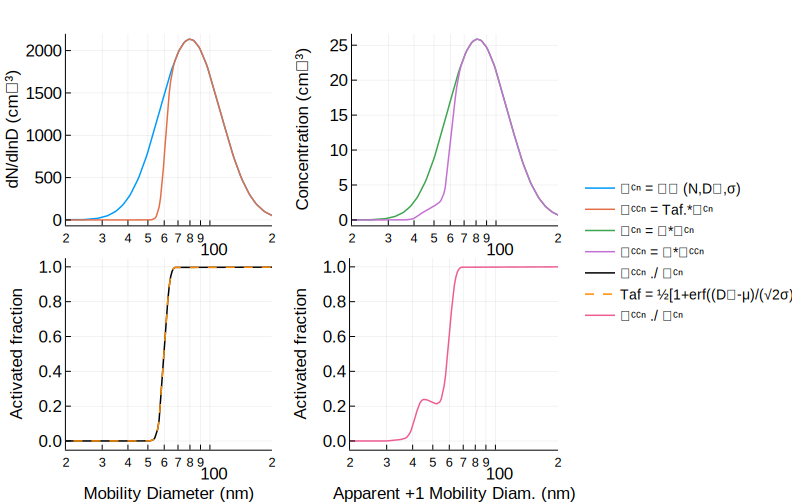

In [4]:
figure("Nimbus Sans L", 2, 5.5, 3.5, 8)  

# Get a list of colors from the theme palette
p = Plots.get_color_palette(:auto, default(:bgcolor), 100)

# Panel (a): Mobility size and CCN distribution
p1 = plot(𝕟ᶜⁿ.Dp, 𝕟ᶜⁿ.S, xaxis = :log10, xticks = [10, 100, 1000], ylabel = "dN/dlnD (cm⁻³)", 
    label = "𝕟ᶜⁿ = 𝓛𝓝 (N,Dₘ,σ)", color = p[1],  left_margin = 20px)
p1 = plot!(𝕟ᶜᶜⁿ.Dp, 𝕟ᶜᶜⁿ.S, label = "𝕟ᶜᶜⁿ = Taf.*𝕟ᶜⁿ", color = p[2])

# Panel (b): Size and CCN response function 
p2 = plot(𝕣ᶜⁿ.Dp, 𝕣ᶜⁿ.N , xaxis = :log10, xticks = [10, 100, 1000], label = "𝕣ᶜⁿ = 𝐀*𝕟ᶜⁿ", 
    ylabel = "Concentration (cm⁻³)", color = p[3])
p2 = plot!(𝕣ᶜᶜⁿ.Dp, 𝕣ᶜᶜⁿ.N, label = "𝕣ᶜᶜⁿ = 𝐀*𝕟ᶜᶜⁿ", color = p[4], left_margin = 36px)

# Panel (c): Activated fraction. Note that g and 𝕒𝕗₁ are identical
p3 = plot(𝕒𝕗₁.Dp, 𝕒𝕗₁.S, xaxis = :log10, xticks = [10, 100, 1000], xlabel = "Mobility Diameter (nm)", 
    ylabel = "Activated fraction", label = "𝕟ᶜᶜⁿ ./ 𝕟ᶜⁿ", ylim = (-0.05,1.05), lw = 1.5, 
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1], color = :black,  left_margin = 20px)
p3 = plot!(𝕟ᶜⁿ.Dp, Taf(𝕟ᶜⁿ,μ,σ), label = "Taf = ½[1+erf((Dₚ-μ)/(√2σ)]", ls = :dash, 
    color = :darkorange, lw = 1.5)

# Panel (d): Activated fraction from response function ("measured ratio" from raw signal)
p4 = plot(𝕒𝕗₂.Dp, 𝕒𝕗₂.S, xaxis = :log10, xticks = [10, 100, 1000],  
    xlabel = "Apparent +1 Mobility Diam. (nm)", ylim = (-0.05,1.05), label = "𝕣ᶜᶜⁿ ./ 𝕣ᶜⁿ", 
    color = p[7], ylabel = "Activated fraction", yticks = [0, 0.2, 0.4, 0.6, 0.8, 1], left_margin = 20px)

plot(p1,p2,p3,p4, layout = grid(2,2), lw = 1.5, right_margin = 30px, 
    xlim = (20,200), legend=:right, top_margin = 15px, fmt = :svg)

<figcaption><b> Figure 2. </b> Top left: Lognormal mobility size distribution (CN) assumed to be known (blue) and CCN size distribution calculated from the assumed size distribution and the CCN transmission function based on an assumed D50 activation diameter of (μ=60 nm) and standard deviation (σ = 8nm). Top right: CN and CCN response funcion computed from size and CCN distribution and the convolution matrix. Bottom left: ratio of  CCN and CN size distribution superimposed on the CCN transmission function. These are by definition equal. Bottom right, right of CCN and CN response function. </figcaption> 

Figure 2 bottom right demostrates the presence of a shoulder of particles activating at 45 nm. These are +2 charged particles transmitting through the DMA that influence of +2 the observed ratio 𝕣ᶜᶜⁿ./𝕣ᶜⁿ. Petters et al. (2007) used a non-matrix based forward solution of the Fredholm integral equation (Notebook S2) to compute 𝕣ᶜᶜⁿ./𝕣ᶜⁿ and fit an optimal solution through data. Petters et al. (2009) used an simple inversion method to find 𝕟ᶜᶜⁿ./𝕟ᶜⁿ, from which the activated fraction and D50 were determined. Neither method is quick to reproduce. Below it is demonstrated how the formalism introduced with DifferentialMobilityAnalyzer.jl greatly simplifies finding D50 from actual CCN data. 
## Block 5. Application to Synthetic  Data
This block demonstrates how to use DifferentialMobilityAnalyzer.jl to work with synthetic CCN data. Here the objective is to find the activation diameter when only the noisy response is known, as is the case with measurements. A noisy response function is simulated as in Notebook S4. The ideal response function is computed via 𝕣 = $\mathbf{A}*$𝕟. Then the number of counts are computed based on detector sample flow rate (1 L min⁻¹ for the CPC and 0.05 L min⁻¹ for the CCN). A random number generator is simulating a Poisson distributed random variate with mean equaling the counts. The noisy response function is thresholded at low concentrations. This is necessary because at low concentrations a bin may have zero or very low concentration, resulting in unrealistic or NaN/InF values in the activated fraction array. The data are then inverted and the activation diameter is obtained via a non-linear least square fit, as would be the case with a real dataset.

### (a) Define DMA

In [5]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 60, dtoz(Λ,300e-9), dtoz(Λ,30e-9)   # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

The section generates the noisy CN and CCN response function using the random number gnerator. Thresholding is performed for bins with low counts. If counts/concentration is below the threhold, the activated fraction is forced to one for large diameters and zero for small diameters. The noise threshold may need to be adjusted for different datasets.

In [6]:
𝕟ᶜⁿ = DMALognormalDistribution([[7000.0, 80, 1.4]], δ)
Taf = (x,μ,σ) -> @. 0.5 .* (1.0 .+ erf.((x .- μ)/(sqrt(2σ))))
tscan = 180        # SMPS scan time [s] 
Qcpc = 16.66       # CPC flow rate [cm³ s⁻¹]. 16.66 cm³ s⁻¹ = 1 L min⁻¹
Qccn = 0.05*16.66  # CCN sample flow rate [cm³ s⁻¹]. 16.66 cm³ s⁻¹ = 1 L min⁻¹
t = tscan./bins    # time in each bin
Random.seed!(705)
μ,σ = 60,8
𝕣ᶜⁿ = δ.𝐀*𝕟ᶜⁿ;                     # DMA response function 
𝕣ᶜᶜⁿ = δ.𝐀*(Taf(δ.Dp,μ,σ)*𝕟ᶜⁿ);   # DMA response function 
cᶜⁿ = 𝕣ᶜⁿ.N*Qcpc*t;                # number of counts in each bin
cᶜᶜⁿ = 𝕣ᶜᶜⁿ.N*Qccn*t;              # number of CCN counts in each bin

Rcn = Float64[]    # Construct a noisy response function 𝕣+ϵ, where ϵ is counting uncertainty
Rccn = Float64[]   # Construct a noisy response function 𝕣+ϵ, where ϵ is counting uncertainty
for i = cᶜⁿ
    f = rand(Poisson(i),1)     # draw Poisson random number with mean = counts
    push!(Rcn,f[1]/(Qcpc*t))   # convert back to concentration
end

for i = cᶜᶜⁿ
    f = rand(Poisson(i),1)      # draw Poisson random number with mean = counts
    push!(Rccn,f[1]/(Qccn*t))   # convert back to concentration
end

𝕣ᶜⁿ.N, 𝕣ᶜᶜⁿ.N  = Rcn, Rccn;

function threshold(𝕟::SizeDistribution, c::Float64, n1::Float64, n2::Float64)
   N = 𝕟.N  
   N[(N .<= c) .& (𝕟.Dp .> 150)] .= n1
   N[(N .<= c) .& (𝕟.Dp .> 150)] .= n2
   𝕟.N = N
end

threshold(𝕣ᶜⁿ, 6.0, 0.1, 0.1);
threshold(𝕣ᶜᶜⁿ, 6.0, 0.0, 0.1);

The data are inverted using the regularized inversion (Notebook S4). The regularized inverted size distributions are are also thresholded for the same reason as above. Zero concentrations in the CN array or division of two noisy numbers results in unrealistic activated fractions that interfere with the least-square fitting model. <br>

### (b) Fitting Model
There are two ways to fit the response data. Possibility one is to compute the activated fraction from the inverted data and then fit the ratio to the activation model
<center> $T_{\mu,\sigma} = \frac{1}{2}\left[1 + \mathrm{erf}\left(\frac{d-\mu}{\sigma}\right) \right] $ </center>
to find the μ,σ that best describes the data. An alternative method is to compute the regularized inverse from the the CN response function and use it to predict the ratio of 𝕣ᶜⁿ./𝕣ᶜᶜⁿ. In this case the model is
<center> $𝕟^{\mathrm{cn}} = (\bf{A}^\rm{T}\bf{A} + \lambda^\rm{2} \bf{I})^\rm{-1}(\bf{A}^\rm{T} \rm{𝕣^{\mathrm{cn}}} - \lambda^2\bf{S}^{-1} \rm{𝕣^{\mathrm{cn}}})$ </center>
<center> $\left( \frac{𝕣^{\mathrm{cn}}}{𝕣^{\mathrm{cn}}} \right)_{\mathrm{model}} = \frac{\mathbf{A}[T_{\mu,\sigma}\; .*\; 𝕟^{\mathrm{cn}}]}{\mathbf{A}𝕟^{\mathrm{cn}}}$ </center>
Methods 1 and 2 mirror the approaches in Petters et al. (2009) and Petters et al. (2007), respectively. However, the previously published approaches neither used regularization nor the formalism described here. <br>

Using the formalized approach, the model formulation and fitting procedure become simple and can be solved in few lines of code.
```julia
𝕟ᶜⁿ = rinv(𝕣ᶜⁿ.N, δ, λ₁= 1e-3, λ₂=1e1)
model(x,p) = (δ.𝐀*(𝕟ᶜⁿ.N.*Taf(δ.dp, p[1], p[2])))./(δ.𝐀*𝕟ᶜⁿ.N)
fit = curve_fit(model, δ.Dp, 𝕣ᶜᶜⁿ.N./𝕣ᶜⁿ.N, [65.0, 3.0])
```
Note that least square library is not setup to take the SizeDistribution data type, and thus the operation is performed on the number field of these objects. 

In [7]:
𝕟ᶜⁿ = rinv(𝕣ᶜⁿ.N, δ, λ₁= 1e-3, λ₂=1e1)
𝕟ᶜᶜⁿ = rinv(𝕣ᶜᶜⁿ.N, δ, λ₁= 1e-3, λ₂=1e1)
threshold(𝕟ᶜⁿ, 60.0, 0.1, 0.1)
threshold(𝕟ᶜᶜⁿ, 60.0, 0.0, 0.1)
𝕒𝕗₁ =  𝕟ᶜᶜⁿ/𝕟ᶜⁿ           # ratio of CCN to CN based on inverted data

model(x,p) = (δ.𝐀*(𝕟ᶜⁿ.N.*Taf(δ.Dp, p[1], p[2])))./(δ.𝐀*𝕟ᶜⁿ.N)
fit = curve_fit(model, δ.Dp, 𝕣ᶜᶜⁿ.N./𝕣ᶜⁿ.N, [65.0, 3.0])
Ax = fit.param;
DataFrame(μ=round(Ax[1],digits=1), σ=round(Ax[2],digits=1))

,μ,σ
,Float64,Float64
1,60.2,8.8


<b> Table 1. </b> Best fit μ, σ obtained from the least-square algorithm. 

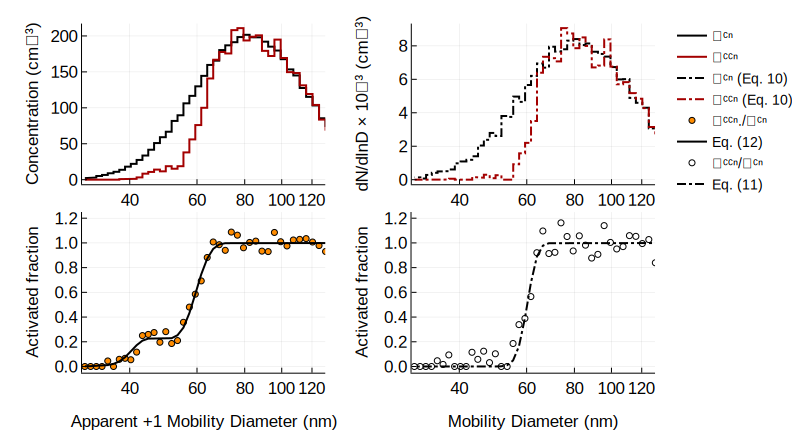

In [8]:
figure("Nimbus Sans L", 2, 5.5, 3, 8)
pre = 1e-3

p1 = plot(δ.Dp, 𝕣ᶜⁿ.N, xaxis = :log10, xticks = [10, 100, 1000], ylabel = "Concentration (cm⁻³)", 
    label = "𝕣ᶜⁿ",  color = :black, lt = :steppre)
p1 = plot!(δ.Dp, 𝕣ᶜᶜⁿ.N, label = "𝕣ᶜᶜⁿ", color = RGBA(163/255,0,0,1), lt = :steppre,
        left_margin = 40px)

p2 = plot(𝕟ᶜⁿ.Dp, pre.*𝕟ᶜⁿ.S, xaxis = :log10, xticks = [10, 100, 1000], 
     ylabel = "dN/dlnD × 10⁻³ (cm⁻³)",  label = "𝕟ᶜⁿ (Eq. 10)", color = :black, 
     ls = :dashdot, lt = :steppre)
p2 = plot!(𝕟ᶜᶜⁿ.Dp, pre.*𝕟ᶜᶜⁿ.S, label = "𝕟ᶜᶜⁿ (Eq. 10)", color = RGBA(163/255,0,0,1), 
    ls = :dashdot, lt = :steppre, left_margin = 52px)

p3 = scatter(δ.Dp, 𝕣ᶜᶜⁿ.N./𝕣ᶜⁿ.N, xaxis = :log10, xticks = [10, 100],  
    xlabel = "Apparent +1 Mobility Diameter (nm)", ms = 3, 
    ylabel = "Activated fraction", ylim = (-0.05,1.25), label = "𝕣ᶜᶜⁿ./𝕣ᶜⁿ", markercolor = :darkorange,
     left_margin = 30px)

p3 = plot!(δ.Dp, model(δ.Dp, Ax), label = "Eq. (12)", color = :black , lw = 2)

p4 = scatter(𝕒𝕗₁.Dp, 𝕒𝕗₁.N, xaxis = :log10, xticks = [10, 100, 1000], ms = 3,
    xlabel = "Mobility Diameter (nm)", ylabel = "Activated fraction", label = "𝕟ᶜᶜⁿ/𝕟ᶜⁿ", 
    markercolor = :white, ylim = (-0.05,1.25), left_margin = 25px)

p4 = plot!(δ.Dp, Taf(δ.Dp,Ax[1],Ax[2]), label = "Eq. (11)", color = :black, lw = 2, ls = :dashdot)

plot(p1,p2,p3,p4, layout = grid(2,2),  bottom_margin = 10px, xlim =(30,130), 
    legend = :topright, lw = 2, right_margin = 20px, fmt = :svg)

<b> Figure 3. </b> Top left: Synthetic noisy response functions for CN and CCN instruments. Note that the CCN response function is more noisy due to the smaller sample flow rate. Top right: inverted CN and CCN size distribution. Bottom left: circles are the ratio of CCN and CN response functions from the synthetic data. The solid line corresponds to the model with the parameters returned from the least-square fit. Bottom right: circles are the ratio of CCN and CN concentration from the regualurized inverse of the response function. The line corresponds the activation model using the parameters returned from the least-square fit. Note that for D > ~200 nm the activated fraction is set to unity and for D < ~35 nm is set to zero by threholding applied. Further note that the inversion removes the shoulder to the left of the true activation diameter, as is expected. Finally, note that the activated fraction is more noisy in the bottom right plot relative to the bottom left plot. 

## Summary and Conclusions
Figure 3 demonstrates how the convolution matrix and size distribution arithmetic can be applied straightforwardly to fit response curves to correctly invert noisy data. The synthetic example can also be used to evaluate the effect of counting uncertainty on the resulting spectra. The noise in the activated fraction is determined by the number of counts in both instruments. Counting statistics are affected by scan rate, bin size, aerosol number concentration, and shape of the size distribution. The testbed can be used to optimize instrument configuration for expected experimental conditions.

## References

Cruz, C. N. and S. N. Pandis (1997). A study of the ability of pure secondary organic aerosol to act as cloud condensation nuclei. Atmospheric Environment 31, 2205–2214, DOI:10.1016/S1352-2310(97)00054-X.

Petters, M. D., A. J. Prenni, S. M. Kreidenweis, P. J. DeMott (2007) On measuring the critical diameter of cloud condensation nuclei using mobility selected aerosol, Aerosol Science & Technology, 41(10), 907-913, doi:10.1080/02786820701557214.

Petters, M. D., C. M. Carrico, S. M. Kreidenweis, A. J. Prenni, P. J. DeMott, J. R. Collett Jr., and H. Moosmüller (2009) Cloud condensation nucleation ability of biomass burning aerosol, Journal Geophysical Research, 114, D22205, doi:10.1029/2009JD012353.

Snider, J. R., M. D. Petters, P. Wechsler, and P. S. K. Liu, (2006), Supersaturation in the Wyoming CCN instrument, Journal Atmospheric Oceanic Technology, 23, 1323-1339, doi:10.1175/JTECH1916.1. 